In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib agg

import visualization
from data import datasets, evaluation
import transformations
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.core import freeze
import optax
import json
import os
import inference
from utils import settings, evaluation
import global_settings

rng_key = jax.random.PRNGKey(0)

dataset_names = [
    "airfoil",
    "boston",
    "concrete",
    "diabetes",
    "energy",
    "forest_fire",
    "wine",
    "yacht"
]

current_dataset = "airfoil"

In [4]:
with open(os.path.join(os.path.join(global_settings.PATH_DATASETS, "benchmark_data"), "dataset_indices_0.2.json"), 'r') as f:
    indices = json.load(f)
#with open(os.path.join(global_settings.PATH_DATASETS, "toy_dataset_indices_0.2.json"), 'r') as f:
#    indices = json.load(f)

In [3]:
split = {
    "data_train": indices[current_dataset]["train"],
    "data_validate": [],
    "data_test": indices[current_dataset]["validate"]
}
#dataset = datasets.Izmailov(split=split)
#dataset = datasets.Sinusoidal()
dataset = datasets.GenericBenchmark(dataset_name=current_dataset, split=split)

In [4]:
model_transformation = transformations.Sequential([
    nn.Dense(3),
    nn.tanh,
    nn.Dense(1)
])

In [5]:
# optimization
rng_key, rng_key_ = jax.random.split(rng_key)

point_estimate = inference.PointEstimate(
    model_transformation=model_transformation,
    dataset=dataset,
    optimizer = optax.adam(learning_rate=0.01),
    rng_key=rng_key_
)

In [6]:
point_estimate.run(
    loss_function=inference.ridge_loss,
    epochs=10001,
    report_at=100
)

epoch 0 loss_train: 718.0205078125 loss_test: 161.13987731933594
epoch 100 loss_train: 61.16486740112305 loss_test: 8.98252010345459
epoch 200 loss_train: 19.201278686523438 loss_test: 5.259675025939941
epoch 300 loss_train: 8.248492240905762 loss_test: 2.8045785427093506
epoch 400 loss_train: 3.459829330444336 loss_test: 1.599393367767334
epoch 500 loss_train: 2.2469916343688965 loss_test: 1.521308422088623
epoch 600 loss_train: 1.6385035514831543 loss_test: 1.652674674987793
epoch 700 loss_train: 1.1996231079101562 loss_test: 1.9889230728149414
epoch 800 loss_train: 0.5125207901000977 loss_test: 2.6426405906677246
epoch 900 loss_train: -0.8750762939453125 loss_test: 2.9761276245117188
epoch 1000 loss_train: -3.2210025787353516 loss_test: 3.1872048377990723
epoch 1100 loss_train: -5.895211219787598 loss_test: 5.679697036743164
epoch 1200 loss_train: -7.185077667236328 loss_test: 6.873147964477539
epoch 1300 loss_train: -7.654424667358398 loss_test: 7.501476764678955
epoch 1400 loss_tr

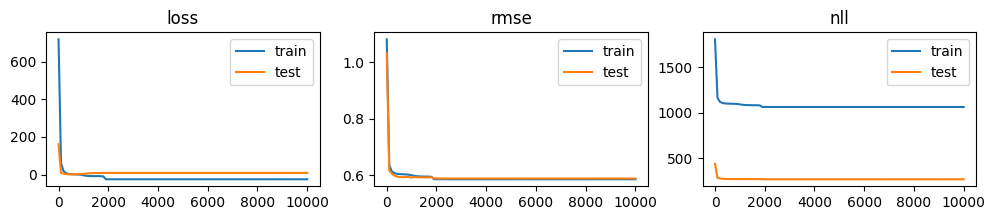

In [7]:
point_estimates = [point_estimate]

import matplotlib.pyplot as plt
figure = plt.figure(figsize=(12, 2))
ax1 = figure.add_subplot(1, 3, 1)
ax1.set_title("loss")

ax2 = figure.add_subplot(1, 3, 2)
ax2.set_title("rmse")

ax3 = figure.add_subplot(1, 3, 3)
ax3.set_title("nll")
for i in range(len(point_estimates)):
    history = point_estimates[i].history
    epoch_history = []
    loss_train_history = []
    loss_test_history = []
    rmse_train_history = []
    rmse_test_history = []
    nll_train_history = []
    nll_test_history = []
    for epoch in history.keys():
        epoch_history.append(epoch)
        loss_train_history.append(history[epoch]["loss_train"])
        loss_test_history.append(history[epoch]["loss_test"])
        rmse_train_history.append(history[epoch]["rmse_train"])
        rmse_test_history.append(history[epoch]["rmse_test"])
        nll_train_history.append(history[epoch]["nll_train"])
        nll_test_history.append(history[epoch]["nll_test"])
    epoch_history = jnp.array(epoch_history)
    loss_train_history = jnp.array(loss_train_history)
    loss_test_history = jnp.array(loss_test_history)
    rmse_train_history = jnp.array(rmse_train_history)
    rmse_test_history = jnp.array(rmse_test_history)
    nll_train_history = jnp.array(nll_train_history)
    nll_test_history = jnp.array(nll_test_history)
    
    ax1.plot(epoch_history, loss_train_history, label="train")
    ax1.plot(epoch_history, loss_test_history, label="test")
    ax2.plot(epoch_history, rmse_train_history, label="train")
    ax2.plot(epoch_history, rmse_test_history, label="test")
    ax3.plot(epoch_history, nll_train_history, label="train")
    ax3.plot(epoch_history, nll_test_history, label="test")
    ax1.legend()
    ax2.legend()
    ax3.legend()
figure

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.84it/s]


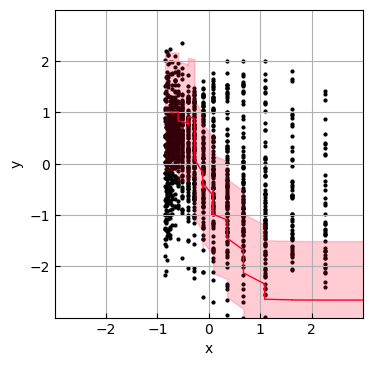

In [8]:
parameters_transformation = jax.tree_util.tree_reduce(lambda a, b: jnp.concatenate([a.flatten(), b.flatten()]), point_estimate.parameters["transformation"])[jnp.newaxis]

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=1.0,
            aleatoric=True
        )
    ),
)
figure.plot(dataset=dataset, transformation=model_transformation.apply_from_vector, parameters_list=[parameters_transformation], std=jnp.exp(point_estimate.parameters["log_std"]))

In [9]:
print(jnp.exp(point_estimate.parameters["log_std"]))

0.585076
